# Packages

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from covid19model.models.base import BaseModel
from covid19model.data.utils import construct_initN
import multiprocessing as mp
from covid19model.optimization.objective_fcns import log_prior_uniform, ll_poisson, ll_negative_binomial, log_posterior_probability
from covid19model.optimization import pso, nelder_mead

In [2]:
import warnings
#warnings.filterwarnings("ignore")

# Data

In [3]:
# Load data
data = pd.read_csv(os.path.join(os.getcwd(),'../../data/interim/influenza/dataset_influenza_1718_format.csv'), index_col=[0,1], parse_dates=True)
data = data.squeeze()
# Re-insert pd.IntervalIndex (pd.IntervalIndex is always loaded as a string..)
age_groups = pd.IntervalIndex.from_tuples([(0,5),(5,15),(15,65),(65,120)])
iterables = [data.index.get_level_values('DATE').unique(), age_groups]
names = ['date', 'Nc']
index = pd.MultiIndex.from_product(iterables, names=names)
df_influenza = pd.Series(index=index, name='CASES', data=data.values)

# Model

In [4]:
class influenza_model(BaseModel):
    """
    Simple model for influenza
    """
    
    state_names = ['S','E','Ia','Im','Is','R','D']
    parameter_names = ['beta','sigma','f_a','f_m','gamma_m','gamma_s']
    parameters_stratified_names = [['mu'],]
    stratification = ['Nc']
    coordinates = [None]
    
    @staticmethod
    def integrate(t, S, E, Ia, Im, Is, R, D, beta, sigma, f_a, f_m, gamma_m, gamma_s, mu, Nc):
        
        T = S+E+Ia+Im+Is+R
        dS = -beta*Nc@((Ia+Im)*S/T)
        dE = beta*Nc@((Ia+Im)*S/T) - 1/sigma*E
        dIa = f_a*E/sigma - 1/gamma_m*Ia
        dIm = (1-f_a)/sigma*E-1/gamma_m*Im
        dIs = (1-f_m)/gamma_m*Im-(1/gamma_s)*Is-mu*Is
        dR = f_m/gamma_m*Im+(1/gamma_s)*Is+1/gamma_m*Ia
        dD = mu*Is
        
        return dS, dE, dIa, dIm, dIs, dR, dD   

In [5]:
# Define contact matrix (PolyMod study)
Nc = np.array([[1.3648649, 1.1621622, 5.459459, 0.3918919],
             [0.5524476, 5.1328671,  6.265734, 0.4055944],
             [0.3842975, 0.8409091, 10.520661, 0.9008264],
             [0.2040816, 0.5918367,  4.612245, 2.1428571]])
# Define model parameters, initial states and coordinates
params={'beta':0.10,'sigma':1,'f_a':0,'f_m':1,'gamma_m':1,'gamma_s':8.6,'mu':[0.01, 0.05, 0.08, 0.13],'Nc':np.transpose(Nc)}
init_states = {'S':construct_initN(age_groups).values,'E':construct_initN(age_groups).values/construct_initN(age_groups).values[0]}
coordinates=[age_groups,]

# Set start date and warmup
warmup = 25
start_idx=0
start_date = df_influenza.index.get_level_values('date').unique()[start_idx]
end_date = df_influenza.index.get_level_values('date').unique()[-1] 
sim_len = (end_date - start_date)/pd.Timedelta(days=1)+warmup

# Get initial condition
I_init = df_influenza.loc[start_date]

# Initialize model
model = influenza_model(init_states,params,coordinates)

In [6]:
out = model.sim(sim_len,start_date=start_date, warmup=warmup)

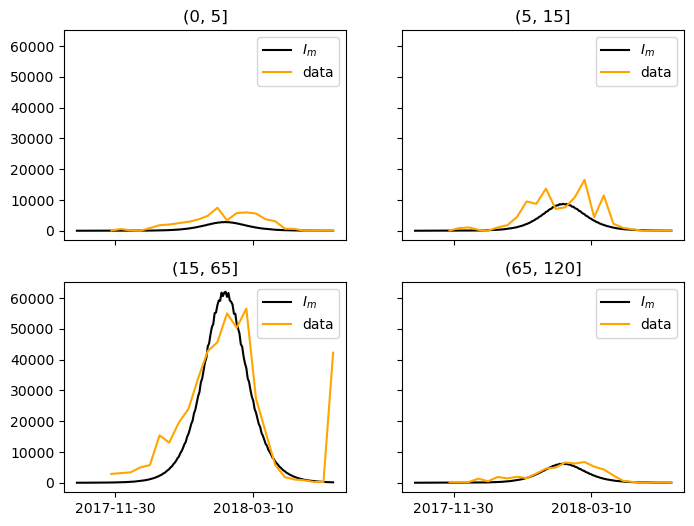

In [7]:
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(8,6))
axs = axs.reshape(-1)
for id, age_class in enumerate(df_influenza.index.get_level_values('Nc').unique()):
    axs[id].plot(out['time'],out.sel(Nc=age_class)['Im'], color='black')
    axs[id].plot(df_influenza.index.get_level_values('date').unique(),df_influenza.loc[slice(None),age_class], color='orange')
    axs[id].set_title(age_class)
    axs[id].legend(['$I_{m}$','data'])
    axs[id].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[id].grid(False)
plt.show()

# Calibration

## Settings

## optimalization 

In [8]:
if __name__ == '__main__':
        # Maximum number of PSO iterations
    n_pso = 10
    # Maximum number of MCMC iterations
    n_mcmc = 10

    # PSO settings
    #processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()/2))
    processes = 1
    multiplier_pso = 20
    maxiter = n_pso
    popsize = multiplier_pso*processes
    # MCMC settings
    multiplier_mcmc = 20
    max_n = n_mcmc
    print_n = 20
    # Define dataset
    data=[df_influenza[start_date:end_date], ]
    states = ["Im",]
    weights = np.array([1,]) # Scores of individual contributions: Dataset: 0, total ll: -4590, Dataset: 1, total ll: -4694, Dataset: 2, total ll: -4984
    log_likelihood_fnc = [ll_poisson,]
    log_likelihood_fnc_args = [[],]


    pars = ['beta','f_a']
    bounds = [(0,1),(0,1)]
    # Setup prior functions and arguments
    log_prior_fnc = len(bounds)*[log_prior_uniform,]
    log_prior_fnc_args = bounds


    # Setup objective function without priors and with negative weights 
    objective_function = log_posterior_probability([],[],model,pars,data,states,
                                               log_likelihood_fnc,log_likelihood_fnc_args,-weights)
    # PSO
    out_PSO = pso.optimize(objective_function, bounds, kwargs={'simulation_kwargs':{'warmup': warmup}},
                       swarmsize=multiplier_pso*processes, maxiter=n_pso, processes=processes, debug=True)[0]
    # A good guess
    theta = [0.1,0]         
    # Nelder-mead
    #step = len(bounds)*[0.01,]
    #theta = nelder_mead.optimize(objective_function, np.array(theta), step, kwargs={'simulation_kwargs':{'warmup': warmup}},processes=processes, max_iter=n_pso)[0]


No constraints given.


## Plot results

In [ ]:
model.parameters.update({'beta':out_PSO[0],'f_a':out_PSO[1]})
out = model.sim(end_date, start_date=start_date, warmup=warmup)

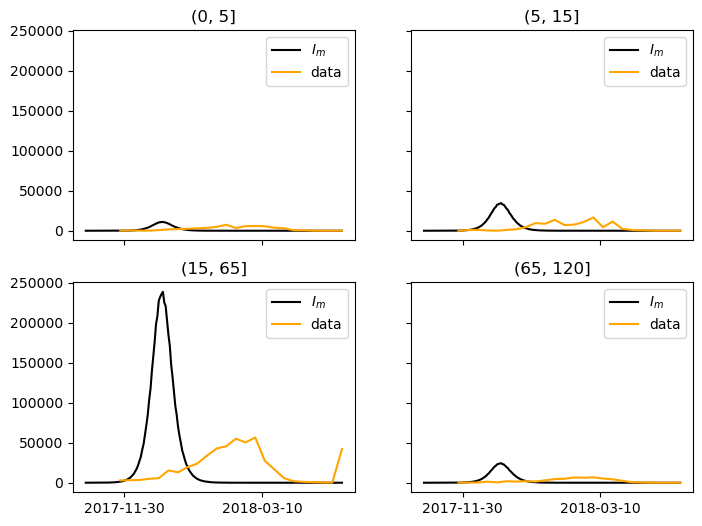

In [ ]:
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(8,6))
axs = axs.reshape(-1)
for id, age_class in enumerate(df_influenza.index.get_level_values('Nc').unique()):
    axs[id].plot(out['time'],out.sel(Nc=age_class)['Im'], color='black')
    axs[id].plot(df_influenza.index.get_level_values('date').unique(),df_influenza.loc[slice(None),age_class], color='orange')
    axs[id].set_title(age_class)
    axs[id].legend(['$I_{m}$','data'])
    axs[id].xaxis.set_major_locator(plt.MaxNLocator(2))
    axs[id].grid(False)
plt.show()